# Reviews classification
In this kernel, i make prediction wether customers is willing to make product recommendation based on their review. i used the tablet data from amazon product review dataset.
Using NLP techniques to normalize text, Random Forest alogrithm is outperform other machine learning classification Techniques and reach about 95% prediction accuracy


In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import nltk
from nltk import sent_tokenize, word_tokenize, pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
from textblob import TextBlob
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from os import path, getcwd
d = getcwd()
import warnings
warnings.filterwarnings('ignore')


# Importing data

In [2]:
review=pd.read_csv("C://Users//my//Desktop//Review.csv")
print("The data has "+str(len(review))+" Row and "+str(len(review.columns))+" columns")

The data has 34660 Row and 21 columns


# Text Normalization

In [3]:
CONTRACTION_MAP = {
"ain't": "is not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he he will have",
"he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have",
"I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have","i'd": "i would","i'd've": "i would have","i'll": "i will",
"i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": "it will",
"it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not",
"needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not",
"sha'n't": "shall not","shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will",
"she'll've": "she will have","she's": "she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have",
"so've": "so have","so's": "so as","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there would",
"there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will",
"they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we would",
"we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not",
"what'll": "what will","what'll've": "what will have","what're": "what are","what's": "what is","what've": "what have","when's": "when is",
"when've": "when have","where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have",
"who's": "who is","who've": "who have","why's": "why is","why've": "why have","will've": "will have","won't": "will not","won't've": "will not have",
"would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would",
"y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would","you'd've": "you would have",
"you'll": "you will","you'll've": "you will have","you're": "you are","you've": "you have"}

In [4]:
# Normalization
# github ("https://github.com/dipanjanS/text-analytics-with-python/blob/master/Old-First-Edition/source_code/Ch04_Text_Classification/normalization.py")
stopword = nltk.corpus.stopwords.words('english')
unwanted_num = {"nor", "no","not"} 

stopword_list = [ele for ele in stopword if ele not in unwanted_num] 

wnl = WordNetLemmatizer()

def tokenize_text(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", " ", expanded_text)
    return expanded_text

from nltk.corpus import wordnet as wn
def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
    
    
    tagged_tokens = tokenize_text(text)
    tagged_text = pos_tag(tagged_tokens)
    
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in tagged_text]
    return tagged_lower_text
    
# lemmatize text based on POS tags    
def lemmatize_text(text):
    
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text
 

def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
    
    
def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Delete the words with length less than 2
def clean_length(text):
    tokens = tokenize_text(text)
    clean_tokens=[token for token in tokens if len(token)>2]
    clean_text=' '.join(clean_tokens)
    return clean_text
    

import re
def remove_num(str):
    string_no_numbers = re.sub("\d+", " ", str)
    return string_no_numbers

def normalize_corpus(corpus, tokenize=False):
    
    normalized_corpus = []    
    for text in corpus:
        text = expand_contractions(text, CONTRACTION_MAP)
        text = clean_length(text)
        text = remove_num(text)
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        text = lemmatize_text(text)

        normalized_corpus.append(text)
        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)
            
    return normalized_corpus

# data preparation

In [5]:
# Get our data
final_data=review[["reviews.text","reviews.doRecommend"]]

# Droping missing values
final_data.dropna(axis=0,inplace=True)

# convert to appropiate type
final_data["reviews.text"]=final_data["reviews.text"].astype(str)
final_data["reviews.doRecommend"]=final_data["reviews.doRecommend"].astype("int64")

# data normalization
final_data["norm_text"]=normalize_corpus(final_data["reviews.text"])

# Feature Engineering

In [6]:
final_data["no_Words"]= final_data["reviews.text"].str.split().str.len() # Finding number of words
final_data["no_char"]=final_data["reviews.text"].apply(lambda x: len(x)) # finding number of characters

final_data["textblob_polarity"]=[TextBlob(review).sentiment.polarity for review in final_data["norm_text"]] # finding sentimet polarity
final_data["textblob_subjectively"]=[TextBlob(review).sentiment.subjectivity for review in final_data["norm_text"]] #finding sentiment subjectivity

# get nouns for each review
def get_noun(text):
    blob = TextBlob(text)
    return [ word for (word,tag) in blob.tags if tag[0] == "N"]
final_data["noun"]=final_data["norm_text"].apply(get_noun)
final_data['nouns'] = final_data['noun'].apply(lambda x: ','.join(map(str, x)))

#get adjectives for each review
def get_adj(text):
    blob = TextBlob(text)
    return [ word for (word,tag) in blob.tags if tag[0] == "J"]
final_data["adj"]=final_data["norm_text"].apply(get_adj)
final_data['Adj'] = final_data['adj'].apply(lambda x: ','.join(map(str, x)))


In [7]:
#get all adjective in each review
def get_adj(text):
    blob = TextBlob(text)
    return [ word for (word,tag) in blob.tags if tag[0] == "J"]
final_data["adj"]=final_data["norm_text"].apply(get_adj)
final_data['Adj'] = final_data['adj'].apply(lambda x: ','.join(map(str, x)))

In [8]:
final_data.head()

,reviews.text,reviews.doRecommend,norm_text,no_Words,no_char,textblob_polarity,textblob_subjectively,noun,nouns,adj,Adj
0,This product so far has not disappointed. My c...,1,this product far not disappointed child love u...,27,143,0.325000,0.783333,"[product, child, love, use, ability, monitor, ...","product,child,love,use,ability,monitor,control...",[disappointed],disappointed
1,great for beginner or experienced person. Boug...,1,great beginner experience person bought gift love,14,75,0.650000,0.675000,"[beginner, experience, person, gift, love]","beginner,experience,person,gift,love",[great],great
2,Inexpensive tablet for him to use and learn on...,1,inexpensive tablet use learn step nabi thrill ...,26,131,0.000000,0.000000,"[tablet, use, step, thrill, skype]","tablet,use,step,thrill,skype","[inexpensive, learn, learn]","inexpensive,learn,learn"
3,I've had my Fire HD 8 two weeks now and I love...,1,fire two week love this tablet great valuewe p...,117,593,0.385556,0.700000,"[fire, week, tablet, member, tablet, shine, lo...","fire,week,tablet,member,tablet,shine,love,acce...","[great, valuewe, prime, able, prime, nice, nic...","great,valuewe,prime,able,prime,nice,nice,brigh..."
4,I bought this for my grand daughter when she c...,1,buy grand daughter come visit set user enter a...,117,613,0.351562,0.533879,"[daughter, visit, age, name, access, sit, cont...","daughter,visit,age,name,access,sit,content,age...","[grand, enter, sure, appropriate, simple, inst...","grand,enter,sure,appropriate,simple,installed,..."


# Data Visualization

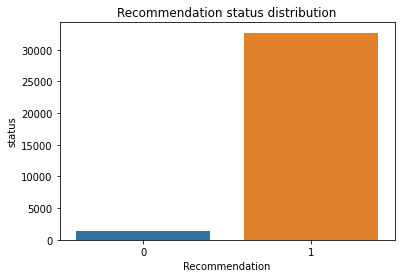

In [9]:
ax=sns.countplot(x="reviews.doRecommend",data=final_data)
plt.title('Recommendation status distribution')
plt.xlabel("Recommendation status")
plt.ylabel('counts')
plt.show()


The bar figures shows high majority of customer recommended the product

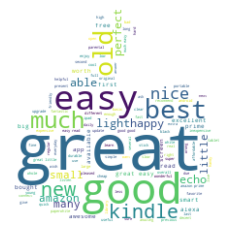

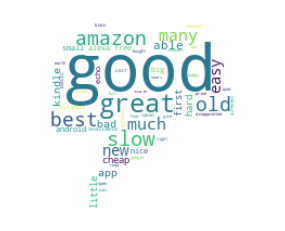

In [10]:
from wordcloud import WordCloud
from PIL import Image

recommended=final_data[final_data["reviews.doRecommend"]==1]
not_recommended=final_data[final_data["reviews.doRecommend"]==0]

recommendation = " ".join(review for review in recommended["Adj"])
no_recommendation=  " ".join(review for review in not_recommended["Adj"])

thump_up = np.array(Image.open('C://Users//my//Desktop//6.jpg'))
ax1 = WordCloud( background_color="white",mask=thump_up,max_font_size=256,width=thump_up.shape[1],height=thump_up.shape[0]).generate(recommendation)
plt.imshow(ax1, interpolation='bilinear')
plt.axis("off")
plt.show()

thump_down = np.array(Image.open('C://Users//my//Desktop//7.jpg'))

ax2 = WordCloud( background_color="white",mask=thump_down,max_font_size=256,width=thump_up.shape[1],height=thump_up.shape[0]).generate(no_recommendation)
plt.imshow(ax2, interpolation='bilinear')
plt.axis("off")
plt.show()





The above wordclouds figures shows how customers describe the products, it shows that even the customers not recommened the product still give good review. some bad reviews may arise describe the product as slow and old


<Figure size 1440x576 with 0 Axes>

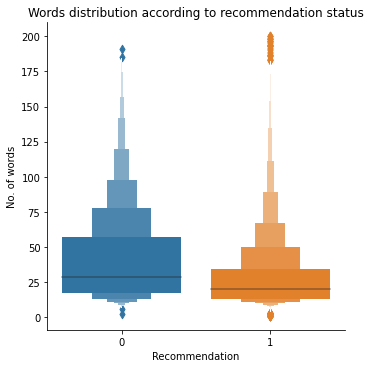

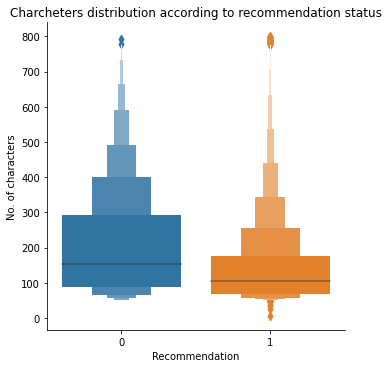

In [11]:
plt.figure(figsize=(20,8))
sns.catplot(y="no_Words", x="reviews.doRecommend", data=final_data[final_data.no_Words<=200],kind='boxen')
plt.title('Words distribution according to recommendation status')
plt.xlabel("Recommendation")
plt.ylabel('No. of words')
plt.show()

sns.catplot(y="no_char", x="reviews.doRecommend", data=final_data[final_data.no_char<=800],kind='boxen')
plt.title('Charcheters distribution according to recommendation status')
plt.xlabel("Recommendation")
plt.ylabel('No. of characters')
plt.show()


you can notice that, in general customers writes longer review if they don't recommended the product.

# Topic modeling

In [78]:
# Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation

# Initialize CountVectorizer
cvectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))

# Fit it to our dataset
cvz = cvectorizer.fit_transform(final_data["norm_text"])

# Initialize LDA Model with 10 Topics
lda_model = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# Fit it to our CountVectorizer Transformation
X_topics = lda_model.fit_transform(cvz)

# Define variables
n_top_words = 20
topic_summaries = []

# Get the topic words
topic_word = lda_model.components_
# Get the vocabulary from the text features
vocab = cvectorizer.get_feature_names()

# Display the Topic Models
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))


Topic 0: wife love | love alexa | like product | love thing | enjoy product | far good | gift family | faster stick | item work | kindle good | bought husband | love recommend | customer service | gift kid | fun family | amazon work | best buy | love perfect | voice recognition | paper white
Topic 1: play music | amazon echo | love echo | ask question | ask alexa | answer question | echo dot | listen music | smart home | home automation | turn light | use echo | echo great | bluetooth speaker | control light | shop list | google home | alexa play | use alexa | voice command
Topic 2: best thing | best stream | love buy | far best | good stick | child love | love best | cut cable | learn new | stream box | new thing | buy product | stream device | product love | work flawlessly | playstation vue | grandkids love | cable cord | love stick | android box
Topic 3: year old | good product | great product | use everyday | parental control | old love | easy use | user friendly | christmas gift 

apparently the customers are token about five main topics<br>
1- ***easy to use*** <br>
2- ***family gift*** <br>
3- ***cost***: worth extra money, cheap <br>
4- ***Good sound system*** <br>
5- ***general description***: like great, good,excellent product

# Modeling

In [13]:
# Preparing the data for model
from scipy.sparse import csr_matrix, hstack
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split

TV = TfidfVectorizer(stop_words='english',ngram_range=(2, 2),max_features=1000)
x_text = TV.fit_transform(final_data['norm_text'])
count_vect_df = pd.DataFrame(x_text.todense(), columns=TV.get_feature_names())

X=pd.merge(count_vect_df, final_data, left_index=True, right_index=True)
X_final=X.drop(["reviews.text","norm_text","noun","nouns","adj","Adj"],axis=1)
X_final.head()

,able download,able play,able read,able set,able use,able watch,absolutely love,access amazon,access internet,add apps,...,year old,young child,young kid,youtube video,yr old,reviews.doRecommend,no_Words,no_char,textblob_polarity,textblob_subjectively
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,27,143,0.325000,0.783333
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,14,75,0.650000,0.675000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,26,131,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,117,593,0.385556,0.700000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,117,613,0.351562,0.533879


After data is ready we now move to next chapter(data modeling). One a side note:Since running all these models take much time i only give the code and final result to show the steps that taken to develop the final model 

# Model 1 ( Original data)

In [14]:

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import SVC

#X_train, X_test, y_train, y_test = train_test_split(X_final.drop(["reviews.doRecommend"],axis=1), X_final["reviews.doRecommend"], test_size=0.3) # 70% training and 30% test
#models=[]
#models.append(("LR",LogisticRegression()))
#models.append(("LDA",LinearDiscriminantAnalysis()))
#models.append(("KNN",KNeighborsClassifier()))
#models.append(("CART",DecisionTreeClassifier()))
#models.append(("RF",RandomForestClassifier()))
#models.append(("NB",GaussianNB()))
#models.append(("SVM",SVC()))

#seed=7
#scoring="accuracy"
#result=[]
#names=[]

#for name,model in models:
    #kfold=model_selection.KFold(n_splits=5,random_state=seed)
    #cv_result=model_selection.cross_val_score(model,X_train,y_train,cv=kfold, scoring=scoring)
    #result.append(cv_result)
    #names.append(name)
    #msg="%s: %f (%f)" % (name,cv_result.mean(),cv_result.std())
    #print(msg)

In this section we tried to pick up the most accurate algorthim that fits with the data, we used 5_fold validation and accuracy scoring to compare between different classification alogrithems and it seems like all models except GaussianNB are doing approximatley the same (accuracy 95.3-95.9%)

# Model 2 (class decomposition)

We used class decomposition techniques since our data suffer from high imbalanced classification. so solving this may lead to accuracy improvement.

In [15]:
def normalize(df,cols):
    for col in cols:
        df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())
    return df

x_normalize=normalize(X_final,X_final.columns)

# Elbow method to find number of clusters for data
def elbow_clusters(df):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title("Elbow method")
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    

# Generate clusters in dataframe based on Elbow method
def clusters(df,n):
    #get the clusters for positive cases
    clusters_model=KMeans(n_clusters=n)
    clusters_model.fit(df)
    df["labels"]=clusters_model.predict(df)
    df["labels"]=df["labels"]+1
    
    return df

# Elbow method to find number of clusters for data
def elbow_clusters(df):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title("Elbow method")
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    

# Generate clusters in dataframe based on Elbow method
def clusters(df,n):
    #get the clusters for positive cases
    clusters_model=KMeans(n_clusters=n)
    clusters_model.fit(df)
    df["labels"]=clusters_model.predict(df)
    df["labels"]=df["labels"]+1
    
    return df

X_pos=x_normalize[x_normalize["reviews.doRecommend"]==1]
X_neg=x_normalize[x_normalize["reviews.doRecommend"]==0]

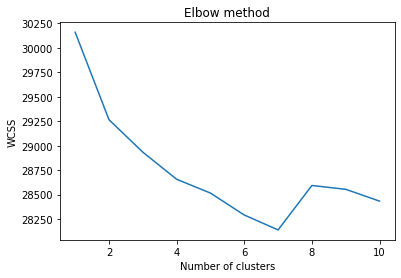

In [16]:
elbow_clusters(X_pos)

In [17]:
clusters(X_pos,2)
X_C = pd.concat([X_pos,X_neg],axis=0)
X_C["labels"].fillna(0,inplace=True)
X_C["labels"].value_counts()

2.0    18632
1.0    13524
0.0     1351
Name: labels, dtype: int64

Class decomposition only decrease the difference between the target variable levels.

In [74]:
#resultC=[]

#for i in range(5):
    #X_trainc, X_testc, y_trainc, y_testc = train_test_split(X_C.drop(["reviews.doRecommend","labels"],axis=1), X_C["labels"], test_size=0.3) 
    #clf=RandomForestClassifier(n_estimators=100)
    #clf.fit(X_trainc,y_trainc)
    #y_predc=clf.predict(X_testc)
    #predicted= np.where((y_predc >=1),1,y_predc)
    #y_testC=np.where((y_testc >=1) ,1,y_testc)
    #resultC.append(accuracy_score(predicted,y_testC))


#print(np.mean(resultC))
#Note:There is no change of the accuracy for random forest with class decompositon(stay steady at 95.8%)

The result shows no significant increase in accuracy after class decompositon 

# Model 3 (Class decomposition and SMOTE)

The previous technique shows the imbalanced classification still exist, in this model we combined class decomposition with oversampling method called SMOTE to increase the representation of small category in the dataset and decrease the imbalanced between target variable categories

In [19]:

#from imblearn.over_sampling import SMOTE
#smote=SMOTE("minority")
#x_sm,y_sm = smote.fit_sample(X_C.drop(["reviews.doRecommend","labels"],axis=1),X_C["labels"])

#resultc_smote=[]
#for i in range(5):
    #X_trainc, X_testc, y_trainc, y_testc = train_test_split(x_sm,y_sm, test_size=0.3) 
    #clf=RandomForestClassifier(n_estimators=100)
    #clf.fit(X_trainc,y_trainc)
    #y_predc=clf.predict(X_testc)
    #predicted= np.where((y_predc >=1),1,y_predc)
    #y_testC=np.where((y_testc >=1) ,1,y_testc)
    #resultc_smote.append(accuracy_score(predicted,y_testC))

#print(np.mean(resultc_smote))



The accuracy for random forest classification with class decomposiiton and smote oversampling is 93.03% which less than 96% 

# Hyperparameter tuning

In [20]:
#copyright:https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

#from sklearn.model_selection import RandomizedSearchCV
# -Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# -Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# -Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# -Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# -Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# -Method of selecting samples for training each tree
#bootstrap = [True, False]
# -Create the random grid
#random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               #'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap}
#print(random_grid)


# -Use the random grid to search for best hyperparameters
# -First create the base model to tune
#rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# -search across 100 different combinations, and use all available cores
#X_train, X_test, y_train, y_test = train_test_split(X_final.drop(["reviews.doRecommend"],axis=1), X_final["reviews.doRecommend"], test_size=0.3,random_state = 42) # 70% training and 30% test
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# -Fit the random search model
#rf_random.fit(X_train, y_train)


#X_train, X_test, y_train, y_test = train_test_split(X_over,y_over, test_size=0.3) # 70% training and 30% test
#clf=RandomForestClassifier(n_estimators=400,min_samples_split=5,min_samples_leaf=1,max_features="sqrt",max_depth=30,bootstrap=True)
#clf.fit(X_train,y_train)
#y_pred=clf.predict(X_test)


parameter tunning for random forest classifier is n_estimators=400,min_samples_split=5,min_samples_leaf=1,max_features="sqrt",max_depth=30,bootstrap=True
Note:The parameter tunning doesn't increase the accuracy and predicted 1 for all data

# Final model

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_final.drop(["reviews.doRecommend"],axis=1), X_final["reviews.doRecommend"], test_size=0.3) # 70% training and 30% test
RFC=RandomForestClassifier(n_estimators=400)
RFC.fit(X_train,y_train)
y_pred=RFC.predict(X_test)
print("Model Accuracy is"+str(confusion_matrix(y_pred,y_test)))
print("Model Precision is"+str(precision_score(y_pred,y_test)))
print("Model Recall is"+str(recall_score(y_pred,y_test)))
print("Model f1 is"+str(f1_score(y_pred,y_test)))


In [65]:
confusion_matrix(y_pred,y_test)

array([[   3,   14],
       [ 385, 9651]], dtype=int64)

# Feature Importance

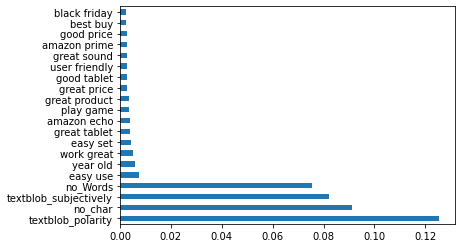

In [77]:
#fitting the model in the original dataset
RFC=RandomForestClassifier(n_estimators=400)
RFC.fit(X_final.drop(["reviews.doRecommend"],axis=1), X_final["reviews.doRecommend"])

feat_importances = pd.Series(RFC.feature_importances_, index=X_final.drop(["reviews.doRecommend"],axis=1).columns)
feat_importances.nlargest(20).plot(kind='barh')
